In [6]:
import numpy as np;
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import cvxopt;
from cvxpy import Minimize, Problem, Variable,norm1,norm2,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy;
d1 = 1.0; 
d2 = 1.0; 
def model(x,t):
    dxdt = [2.0*np.power(1.0+x[1]**1.0, -1.0) - d1*x[0],
            3.0*np.power(1.0+x[0]**1.0, -1.0) - d2*x[1]]
    return dxdt


def uf_singlehill(xi,kMi): #2 of these 
    return 1.0/(kMi+xi);

def uf_doublehill(xi,kMi,xj,kMj): #1 of these 
    return 1.0/(kMi+xi)*1.0/(kMj+xj);


def uf_doubleacthill(xi,kMi,xj,kMj): # 1 of these 
    return xi/(kMi+xi)*xj/(kMj+xj);


def uf_mixedhill(xi,kMi,xj): #2 of these 
    return 1.0/(kMi+xi)*xj;

def uf_bilinearhill(xi,kMi,xj):
    return np.multiply(xi,xj)/(kMi+xi); # 2 of these 

def uf_singleacthill(xi,kMi): # 2 of these 
    return xi/(kMi+xi);



def calc_Koopman(Yf,Yp,flag=1):
    solver_instance = cvxpy.CVXOPT;
    #solver_instance = cvxpy.ECOS;
    if flag==1: # moore penrose inverse, plain ol' least squares Koopman
        #Yp_inv = np.dot(np.transpose(Yp_final), np.linalg.inv( np.dot(Yp_final,np.transpose(Yp_final)) )   );
        Yp_inv = np.linalg.pinv(Yp);
        K = np.dot(Yf,Yp_inv);
        

    if flag ==2: # cvx optimization approach - L2 + L1 lasso 
        norm1_term = 0.0;
        all_col_handles = [None]*Yf.shape[0]
        for i in range(0,Yf.shape[0]):            
            all_col_handles[i] = Variable(Yf.shape[0],1);
            norm1_term = norm1_term + norm2(all_col_handles[i]);

        operator = all_col_handles[0];
        for i in range(1,Yf.shape[0]):
            operator = cvxpy.hstack(operator,all_col_handles[i]);

        print("[INFO]: CVXPY Koopman operator variable: " +repr(operator));
        print("[INFO]: Yf.shape in calc_Koopman: " + repr(Yf.shape));
        norm2_fit_term = norm2(norm2(Yf-operator*Yp,axis=0));
        objective = Minimize(norm2_fit_term + norm1_term)
        constraints = [];
        prob = Problem(objective,constraints);
        result = prob.solve(verbose=True,solver=solver_instance);
        print("[INFO]: Finished executing cvx solver, printing CVXPY problem status")
        print(prob.status);
        K = operator.value;

    if flag ==3:
        operator = Variable(Yf.shape[0],Yf.shape[0])
        objective = Minimize(cvxpynorm(operator,2))
        constraints = [cvxpynorm(Yf-operator*Yp,'fro')/cvxpynorm(Yf,'fro')<0.01 ]
        prob = Problem(objective, constraints)
        result = prob.solve(verbose=True)#(solver=solver_instance);
        print(prob.status);
        K = operator.value;

    return K;


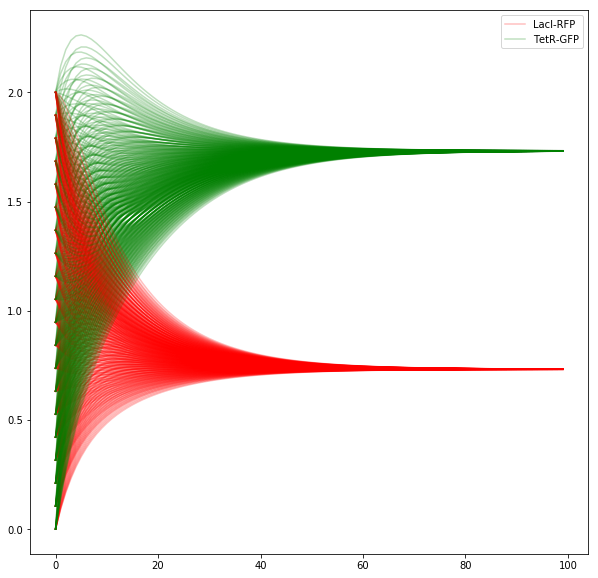

In [7]:
t = np.linspace(0,15,100)
kM=1.0;
# X and Y range
Xrange = np.linspace(0,2,20)
Yrange = np.linspace(0,2,20)
LiftedZ = None;
All_Z = None;
All_Zf = None;
All_Zp = None; 
plt.figure(figsize=(10,10))

for k1 in range(0,len(Xrange)):
    for k2 in range(0,len(Yrange)):
        z0 = [Xrange[k1],Yrange[k2]];
        #print(z0)
        
        Z = odeint(model,z0,t)
        Z  = Z.T;
        plt.plot(Z[0,:],'r',alpha=0.25);
        plt.plot(Z[1,:],'g',alpha=0.25);
        plt.legend(['LacI-RFP','TetR-GFP'])
        LiftedZ = Z;
        for state_ind in range(0,Z.shape[0]):
            UFSH = uf_singlehill(Z[state_ind,:],kM);
            UFSAH = uf_singleacthill(Z[state_ind,:],kM);
            LiftedZ = np.vstack( (LiftedZ,UFSH,UFSAH));
            for state2_ind in range(0,Z.shape[0]):
                if state2_ind > state_ind:
                    UFDH = uf_doublehill(Z[state_ind,:],kM,Z[state2_ind,:],kM);
                    UFDAH = uf_doubleacthill(Z[state_ind,:],kM,Z[state2_ind,:],kM);
                    LiftedZ = np.vstack( (LiftedZ,UFDH,UFDAH));
                if not(state2_ind == state_ind):
                    UFMH = uf_mixedhill(Z[state_ind,:],kM,Z[state2_ind,:]);
                    UFBH = uf_bilinearhill(Z[state_ind,:],kM,Z[state2_ind,:]);
                    LiftedZ = np.vstack( (LiftedZ,UFMH,UFBH));
                
        #print(LiftedZ.shape)
        
        Zf = LiftedZ[:,1:];
        
        
        Zp = LiftedZ[:,0:-1];
        
        if type(All_Zf) == np.ndarray:
            All_Zf = np.hstack((All_Zf,Zf));
            All_Zp = np.hstack((All_Zp,Zp));
            
        else:
            All_Zf = Zf;
            All_Zp = Zp; 





            

Yf = All_Zf;
Yp = All_Zp;




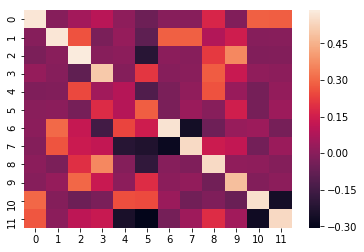

In [8]:
import seaborn as sns

K = calc_Koopman(Yf,Yp,flag=1)

sns.heatmap(K)

In [11]:
np.linalg.norm(Yf-np.dot(K,Yp),2)
Yf-np.dot(K,Yp)

array([[-1.53924437e-03,  6.06759961e-04,  5.02980970e-04, ...,
         1.04033903e-05,  1.04282646e-05,  1.04513260e-05],
       [-9.00439721e-04,  2.96514103e-04,  4.93542921e-04, ...,
         2.73924570e-06,  2.74152211e-06,  2.74359631e-06],
       [-2.36967674e-03,  8.21798805e-04,  1.70222976e-03, ...,
         9.80825519e-06,  9.81398754e-06,  9.81932814e-06],
       ...,
       [ 6.92385354e-03, -2.88010891e-03, -2.53841703e-03, ...,
        -5.77985523e-05, -5.79382900e-05, -5.80682099e-05],
       [-8.24742998e-03,  8.41986250e-04,  1.06730170e-03, ...,
         5.89843476e-05,  5.90441495e-05,  5.90997083e-05],
       [ 6.70818561e-03, -2.35226289e-04, -5.64320726e-04, ...,
        -4.85809573e-05, -4.86158849e-05, -4.86483823e-05]])

In [ ]:
w,V = np.linalg.eig(K)
plt.bar(np.arange(0,len(w),1),w)

In [ ]:
uf_singleacthill(Z[1,:],10.0)
uf_bilinearhill(Z[0,:],10.0,Z[1,:])

In [ ]:
Yp

In [ ]:
x = np.arange(0,20,0.1);
plt.plot((1+x)/(1.0+x**2))
plt.plot(1/(1.0+x))

In [ ]:
plt.plot(.5/(0.5+x))
plt.plot(.5/(0.5+x)**2)